In [1]:
from weavepy import *
sns.set_context("talk")

In [3]:
# Parameters
## Climate
climate_variable = "TA"
climate_variable_comparison = '<=' # '<', '<=', '>', or '>='
climate_variable_threshold = 5 # Number in units of variable
## Energy 
energy_variable = "SPV"
energy_variable_comparison = '<' # '<', '<=', '>', or '>='
energy_variable_threshold = 0.05 # Number in units of variable
## Temporal aggregation
aggregation_frequency = "D"
aggregation_function = "mean"
## Selection
country = "FR"
models = []
scenarios = []
technos = ["NA", "60", "30"]

In [ ]:
data = load_vars([climate_variable, energy_variable], bdd_version = BDD_VERSION,
              countries = ["FR"], technos = ["NA", "60"], models = [], scenarios = [], 
              aggregation_frequency = "D", aggregation_function = "mean",
              verbose=True)

Loading country n°1/1 (FR)
|_Variable n°1/2 (TA)
|__Techno n°1/1 (NA)
|__ > File already exists, loading from cache: /media/cl-ment-devenet/Partage/bdd/cache_data/PECD4.2/TA_NA_D-mean_FR_PECD4.2.nc
|_Variable n°2/2 (SPV)
|__Techno n°1/1 (60)
|__ > File already exists, loading from cache: /media/cl-ment-devenet/Partage/bdd/cache_data/PECD4.2/SPV_60_D-mean_FR_PECD4.2.nc


In [5]:
data

<xarray.Dataset> Size: 62MB
Dimensions:   (time: 55152, country: 1, scenario: 5, model: 7, tech: 2)
Coordinates:
  * time      (time) datetime64[ns] 441kB 1950-01-01 1950-01-02 ... 2100-12-31
  * country   (country) <U2 8B 'FR'
  * scenario  (scenario) <U10 200B 'SP126' 'SP245' 'SP370' 'SP585' 'historical'
  * model     (model) <U9 252B 'AWI-_AWCM' 'BCC-_BCCS' ... 'MRI-_MRM2'
  * tech      (tech) <U2 16B '60' 'NA'
Data variables:
    TA        (time, country, scenario, model, tech) float64 31MB nan ... nan
    SPV       (time, country, scenario, model, tech) float64 31MB nan ... nan

In [7]:
# Identify problematic days
climate_days = identify_pb_days(data[climate_variable], climate_variable_comparison, climate_variable_threshold).rename("climate_event")
energy_days = identify_pb_days(data[energy_variable], energy_variable_comparison, energy_variable_threshold).rename("energy_event")
compound_days = (climate_days & energy_days).rename("compound_event")

In [8]:
climate_days.squeeze()

<xarray.DataArray 'climate_event' (time: 55152, scenario: 5, model: 7, tech: 2)> Size: 4MB
array([[[[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         ...,
...
         ...,
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False,  True],
         [False,  True],
         ...,
         [False, False],
         [False,  True],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]]]], shape=(55152, 5, 7, 2))
Coordinates:
  * time      (time) datetime64[ns] 441kB 1950-01-01 1950-01-02 ... 2100-12-31
    country   <U2 8B 'FR'
  * scenario  (scenario) <U10 200B 'SP126' 'SP245' 'SP370' 'SP585' 'historical'
  * model     (model) <U9 252B 'AWI-_AWCM' 'BCC-_BCCS' ... 'MRI-_MRM2'
  * tech      (tech) <U2 16B '60' 'NA'

In [9]:
# Identify events
climate_events = identify_events_whole_base(climate_days.squeeze())
energy_events = identify_events_whole_base(energy_days)
compound_events = identify_events_whole_base(compound_days)

100%|██████████| 70/70 [00:00<00:00, 418.26it/s]


AttributeError: Can only use .dt accessor with datetimelike values

In [9]:
# Compute number of events per year
N_climate_events = climate_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()
N_energy_events = energy_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()
N_compound_events = compound_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()

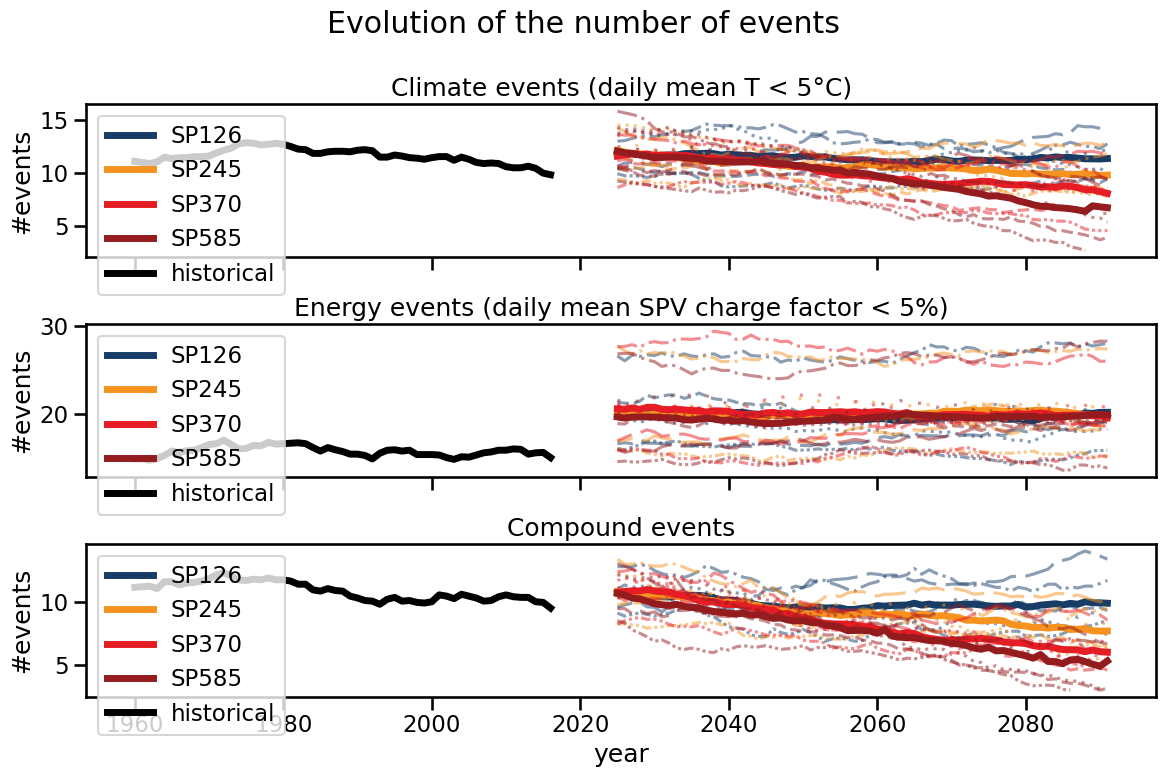

In [10]:
fig, axs = plt.subplots(3, figsize = [12, 8], sharex = True) # TODO: Rolling mean
Nrolls = {}
for i, N in enumerate([N_climate_events, N_energy_events, N_compound_events]):
    for scenario in N_climate_events.scenario.unique():
        Nrolls[str(scenario)] = {}
        for model in N_climate_events.model.unique():
            N2plot = N[(N.scenario == scenario) & (N.model == model)].set_index("year")
            # Raw data
            #N2plot.eventID.plot(ax = axs[i], alpha = 0.25, 
            #                    c = scenario_colors[scenario], linestyle = model_linestyles[model])
            #axs[i].plot(N2plot.year, N2plot.eventID, alpha = 0.5,
            #            c = scenario_colors[scenario], linestyle = model_linestyles[model])
            # Running mean
            Nroll = N2plot.eventID.rolling(20, center = True).mean()
            Nrolls[str(scenario)][str(model)] = Nroll
            Nroll.plot(ax = axs[i], 
                       c = scenario_colors[scenario], 
                       linestyle = model_linestyles[model], 
                      alpha = 0.5)
        mm_mean = pd.concat(list(Nrolls[scenario].values())).rename(scenario).reset_index().groupby("year").mean()
        mm_mean.plot(ax = axs[i], linewidth = 5, color = scenario_colors[scenario],)
    axs[i].set_ylabel("#events")
axs[0].set_title("Climate events (daily mean T < 5°C)")
axs[1].set_title("Energy events (daily mean SPV charge factor < 5%)")
axs[2].set_title("Compound events")
plt.suptitle("Evolution of the number of events")
plt.tight_layout()

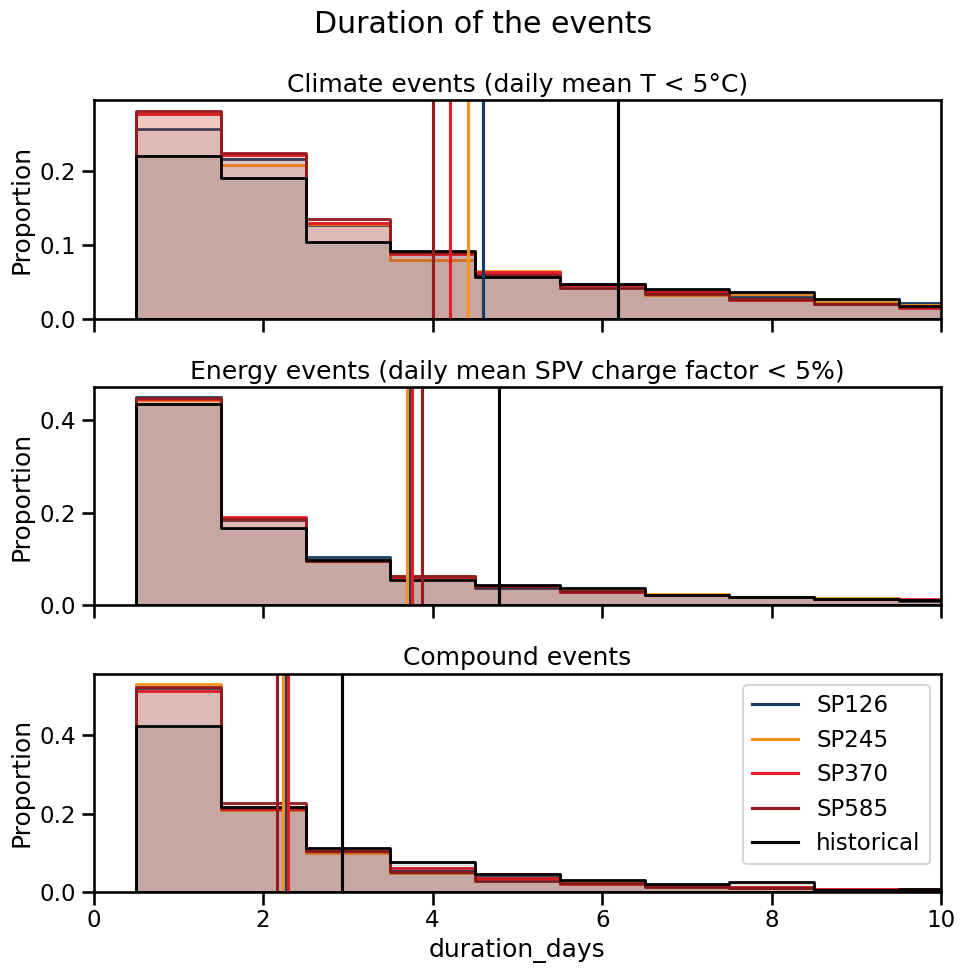

In [11]:
fig, axs = plt.subplots(3, figsize = [10, 10], sharex = True) # TODO: Rolling mean
for i, e in enumerate([climate_events, energy_events, compound_events]):
    e["duration_days"] = e["duration"].astype(int) * 1e-9 / 3600 / 24

    # Scenarios
    for scenario in e.scenario.unique():
        e2plot = e[(e.scenario == scenario)].set_index("year")
        sns.histplot(data = e2plot, x = "duration_days", ax = axs[i], 
        color = scenario_colors[scenario], element = "step", alpha = 0.1,
        bins = np.arange(0.5,30,1), stat = "proportion", linewidth = 2,
        )
        mean = e2plot.duration_days.mean()
        axs[i].axvline(x = mean, color = scenario_colors[scenario], label = scenario)
axs[0].set_title("Climate events (daily mean T < 5°C)")
axs[1].set_title("Energy events (daily mean SPV charge factor < 5%)")
axs[2].set_title("Compound events")
plt.suptitle("Duration of the events")
plt.legend()
plt.xlim(0,10)
plt.tight_layout()

(0.0, 10.0)

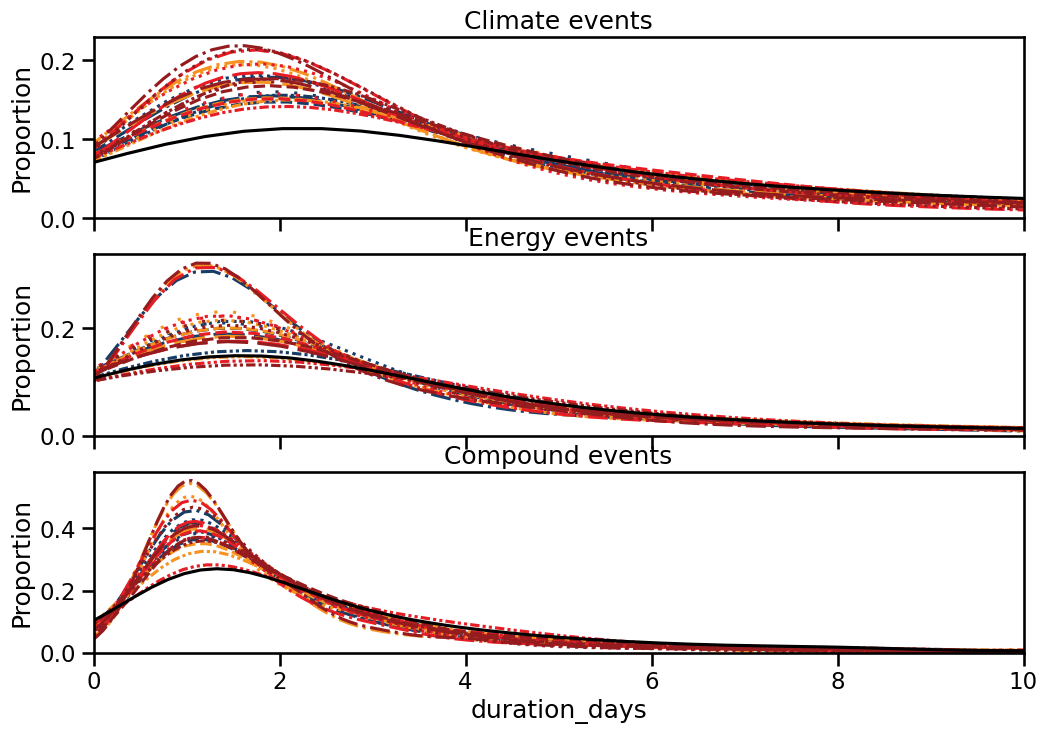

In [12]:
fig, axs = plt.subplots(3, figsize = [12, 8], sharex = True) # TODO: Rolling mean
for i, e in enumerate([climate_events, energy_events, compound_events]):
    e["duration_days"] = e["duration"].astype(int) * 1e-9 / 3600 / 24
    for scenario in e.scenario.unique():
        for model in e.model.unique():
            e2plot = e[(e.scenario == scenario) & (e.model == model)].set_index("year")
            sns.kdeplot(data=e2plot, x= "duration_days", c = scenario_colors[scenario], ax = axs[i], 
                        linestyle = model_linestyles[model], warn_singular=False)
    axs[i].set_ylabel("Proportion")
axs[0].set_title("Climate events")
axs[1].set_title("Energy events")
axs[2].set_title("Compound events")
axs[0].set_xlim(0, 10)

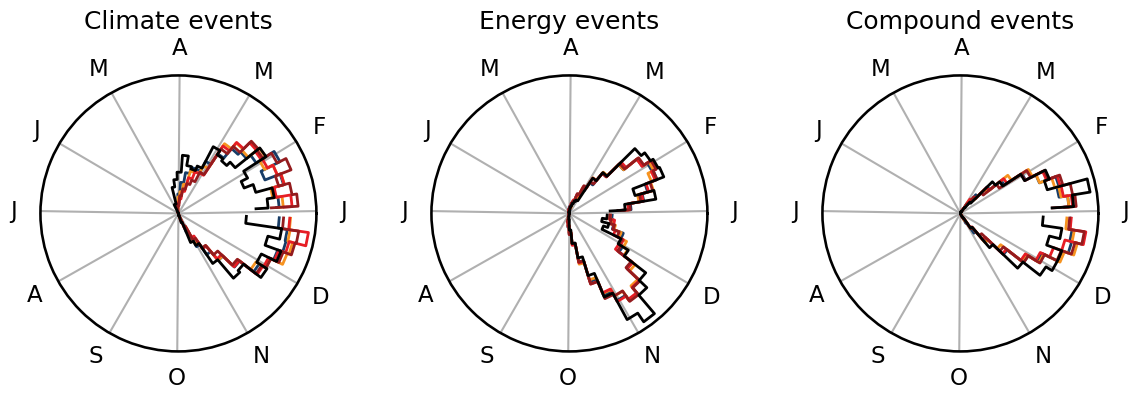

In [13]:
doy_first_day_month = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]

fig, axs = plt.subplots(1, 3, subplot_kw = dict(projection = "polar"), figsize = (12,4))
for i, e in enumerate([climate_events, energy_events, compound_events]):
    e["doy"] = e["start"].dt.dayofyear
    for scenario in e.scenario.unique():
        e2plot = e[(e.scenario == scenario)].set_index("year")
        H = np.histogram(e2plot.doy, bins = np.arange(0.5,366+1,6))
        H_theta = H[1] * 2 * np.pi / 366
        theta_mid = (H_theta[:-1] + H_theta[1:]) / 2
        width = H_theta[1] - H_theta[0]
        N = len(e2plot)
        axs[i].step(theta_mid, H[0]/N, color = scenario_colors[scenario], lw = 2)
    axs[i].set_xticks(np.array(doy_first_day_month) * 2 * np.pi / 366, 'JFMAMJJASOND')
    axs[i].set_yticks([])
axs[0].set_title("Climate events")
axs[1].set_title("Energy events")
axs[2].set_title("Compound events")

plt.tight_layout()

/tmp/ipykernel_460737/254804829.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  kde /= np.trapz(kde, x=bins)
/tmp/ipykernel_460737/254804829.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  kde /= np.trapz(kde, x=bins)
/tmp/ipykernel_460737/254804829.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  kde /= np.trapz(kde, x=bins)


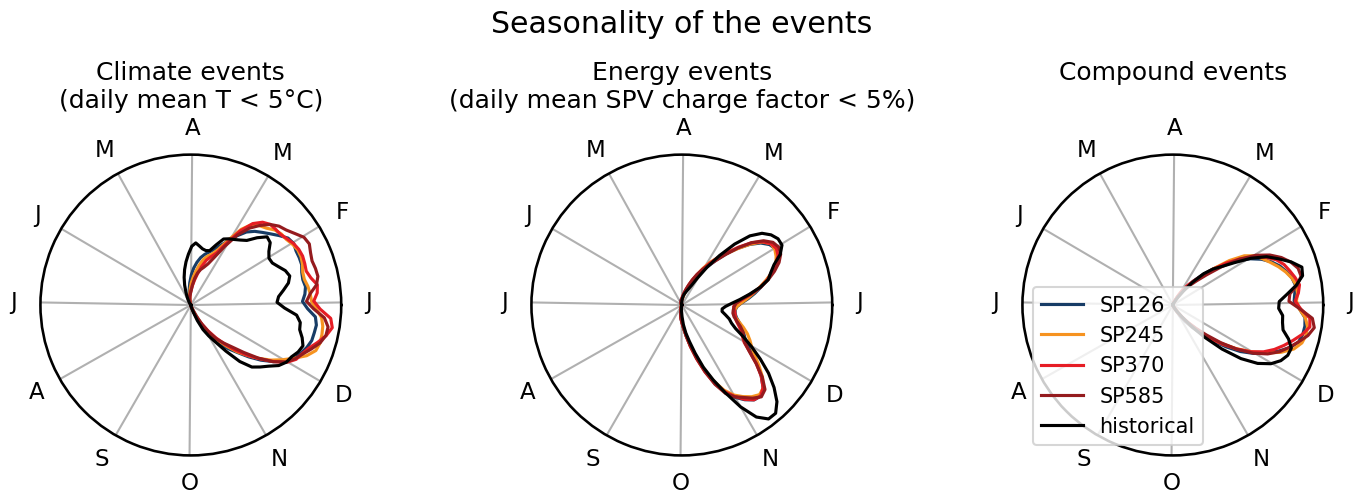

In [14]:
def vonmises_kde(data, kappa, n_bins=100):
    from scipy.special import i0
    bins = np.linspace(-np.pi, np.pi, n_bins)
    x = np.linspace(-np.pi, np.pi, n_bins)
    # integrate vonmises kernels
    kde = np.exp(kappa*np.cos(x[:, None]-data[None, :])).sum(1)/(2*np.pi*i0(kappa))
    kde /= np.trapz(kde, x=bins)
    return bins, kde


#x, kde = vonmises_kde(data, 20)
#axes[1].plot(x, kde)

doy_first_day_month = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]

fig, axs = plt.subplots(1, 3, subplot_kw = dict(projection = "polar"), figsize = (15,5))
for i, e in enumerate([climate_events, energy_events, compound_events]):
    e["doy"] = e["start"].dt.dayofyear
    for scenario in e.scenario.unique():
        e2plot = e[(e.scenario == scenario)].set_index("year")
        x, kde = vonmises_kde(e2plot.doy.values * 2 * np.pi / 366, 180)
        axs[i].plot(x, kde, color = scenario_colors[scenario], label = scenario)
    axs[i].set_xticks(np.array(doy_first_day_month) * 2 * np.pi / 366, 'JFMAMJJASOND')
    axs[i].set_yticks([])
axs[0].set_title("Climate events\n(daily mean T < 5°C)")
axs[1].set_title("Energy events\n(daily mean SPV charge factor < 5%)")
axs[2].set_title("Compound events\n")
axs[2].legend(fontsize = "small", loc = "lower left")
plt.suptitle("Seasonality of the events")

plt.tight_layout()